In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [2]:

from huggingface_hub import login




In [3]:
import pandas as pd

# Login using e.g. `huggingfååace-cli login` to access this dataset
df = pd.read_csv("hf://datasets/ReySajju742/Urdu-Poetry-Dataset/output_ur.csv")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:

df = df.dropna(subset=['content', 'title'])
df['content'] = df['content'].astype(str)

In [5]:
# Extract Labels (Who wrote the poem?)
target_poets = ['ghalib', 'iqbal', 'mir', 'faiz', 'firaq']

def extract_poet(title):
    title = str(title).lower()
    for poet in target_poets:
        if poet in title:
            return poet
    return "other"

df['poet_label'] = df['title'].apply(extract_poet)
df_clean = df[df['poet_label'] != 'other'].copy()

print(f"Loaded {len(df_clean)} poems from {len(target_poets)} poets.")

Loaded 467 poems from 5 poets.


In [6]:
# 1. Labels to Numbers (Ghalib -> 0, Iqbal -> 1, etc.)
encoder = LabelEncoder()
y_data = encoder.fit_transform(df_clean['poet_label'])
num_classes = len(encoder.classes_)

# 2. Text to Numbers (TF-IDF)
# This turns every poem into a list of 2000 numbers based on word importance
vectorizer = TfidfVectorizer(max_features=2000)
X_data = vectorizer.fit_transform(df_clean['content']).toarray()

# 3. Split Training and Testing data
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

print("Data ready for ANN.")

Data ready for ANN.


In [7]:
# CELL 4: Build the ANN Model (The Simpler Part)
# ==========================================
# This is a standard Feed-Forward Neural Network (ANN)
model = keras.Sequential([
    # Input Layer (2000 inputs from TF-IDF)
    layers.Dense(512, activation='relu', input_shape=(2000,)),
    layers.Dropout(0.5), # Helps prevent the model from memorizing (overfitting)

    # Hidden Layer
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),

    # Output Layer (One output per poet)
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# =================================

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │     1,024,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,157,125 (4.41 MB)

 Trainable params: 1,157,125 (4.41 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# CELL 5: Train the Model
# ==========================================
print("\nStarting Training...")
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)


Starting Training...
Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.3999 - loss: 1.5483 - val_accuracy: 0.4255 - val_loss: 1.4212
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.4965 - loss: 1.2791 - val_accuracy: 0.4255 - val_loss: 1.3881
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.5300 - loss: 1.0705 - val_accuracy: 0.4255 - val_loss: 1.2167
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5715 - loss: 0.8643 - val_accuracy: 0.4255 - val_loss: 1.0939
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7006 - loss: 0.7116 - val_accuracy: 0.5426 - val_loss: 0.9484
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9441 - loss: 0.4435 - val_accuracy: 0.6809 - val_loss: 0.8012
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9933 - loss: 0.2312 - val_accuracy: 0.7660 - val_loss: 0.6270
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 1.0000 - loss: 0.0926 - va

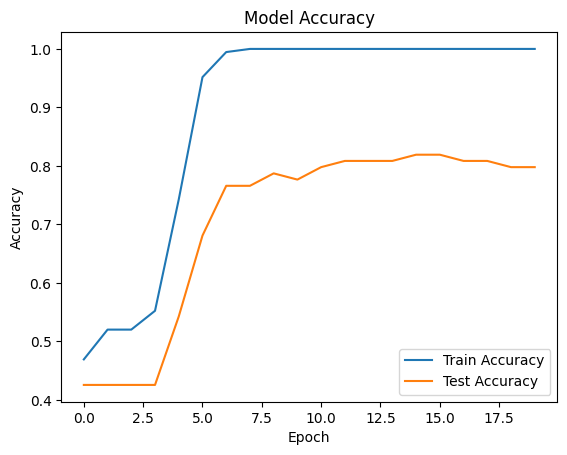

In [9]:
# CELL 6: Plot Results
# ==========================================
#
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [10]:
# CELL 7: Test it Yourself!
# ==========================================
def predict_poet(text):
    # 1. Turn new text into numbers
    vectorized_text = vectorizer.transform([text]).toarray()

    # 2. Predict
    prediction = model.predict(vectorized_text)
    predicted_index = np.argmax(prediction)

    # 3. Get name back
    poet_name = encoder.inverse_transform([predicted_index])[0]
    return poet_name

In [12]:
# Famous Ghalib verse to test
test_verse = "hamaare dil men ab talkhii nahiin hai"
print(f"\nVerse: {test_verse}")
print(f"Predicted Poet: {predict_poet(test_verse)}")


Verse: hamaare dil men ab talkhii nahiin hai
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Predicted Poet: ghalib


In [13]:
test_verse = "khudi ko kar buland itna ke har taqder se pehle"
print(f"Predicted Poet: {predict_poet(test_verse)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted Poet: ghalib


In [14]:
test_verse = "patta patta boota boota haal hamara jaane hai"
print(f"Predicted Poet: {predict_poet(test_verse)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
Predicted Poet: ghalib


In [15]:
# Check how many poems each poet has
print(df_clean['poet_label'].value_counts())

poet_label
ghalib    234
mir        82
faiz       51
firaq      50
iqbal      50
Name: count, dtype: int64
